In [4]:
setwd('/import/DB/workdir/cd40/')

In [5]:
library(Seurat)

In [6]:
da1 = readRDS('./merge.8.9.to.0.rds')

In [7]:
table(da1$orig.ident)


KO3d WT3d 
6816 6149 

In [10]:
da1$celltype = paste0('M',da1$seurat_clusters)

In [11]:
table(da1$celltype)


  M0   M1   M2   M3   M4   M5   M6   M7 
4190 4890 2095  518  382  586   83  221 

In [15]:
sce1 = da1

In [16]:
library(CellChat)
library(patchwork)

In [17]:
Idents(sce1) = 'orig.ident'

In [18]:
table(sce1$orig.ident)


KO3d WT3d 
6816 6149 

In [19]:
Idents(sce1) = 'orig.ident'
ko = subset(sce1,idents = 'KO3d')
wt  = subset(sce1,idents = 'WT3d')

In [20]:
cellchat <- createCellChat(object = wt,
                           meta = wt@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.mouse 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=5)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- projectData(cellchat, PPI.mouse)
library(future)
options(future.globals.maxSize= 4000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 1)
df.net <- subsetCommunication(cellchat)


[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  M0 M1 M2 M3 M4 M5 M6 M7 


An object of class CellChat created from a single dataset 
 34329 genes.
 6149 cells. 
CellChat analysis of single cell RNA-seq data! 

Warning message:
"package 'future' was built under R version 4.2.3"

Attaching package: 'future'


The following objects are masked from 'package:igraph':

    %->%, %<-%




triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-07-04 14:09:31]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-07-04 14:14:25]"


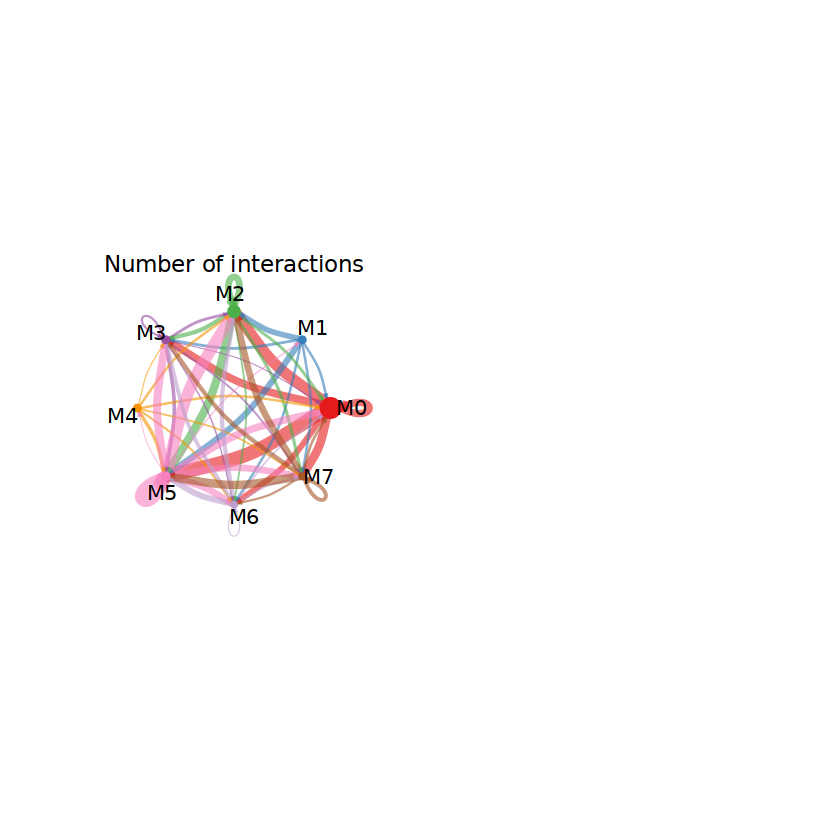

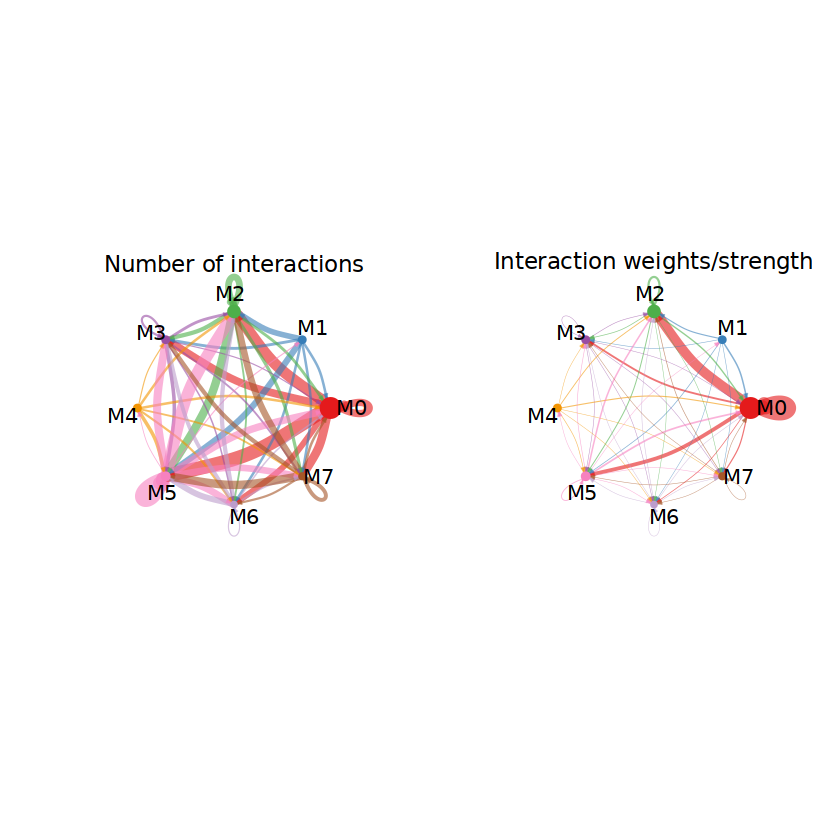

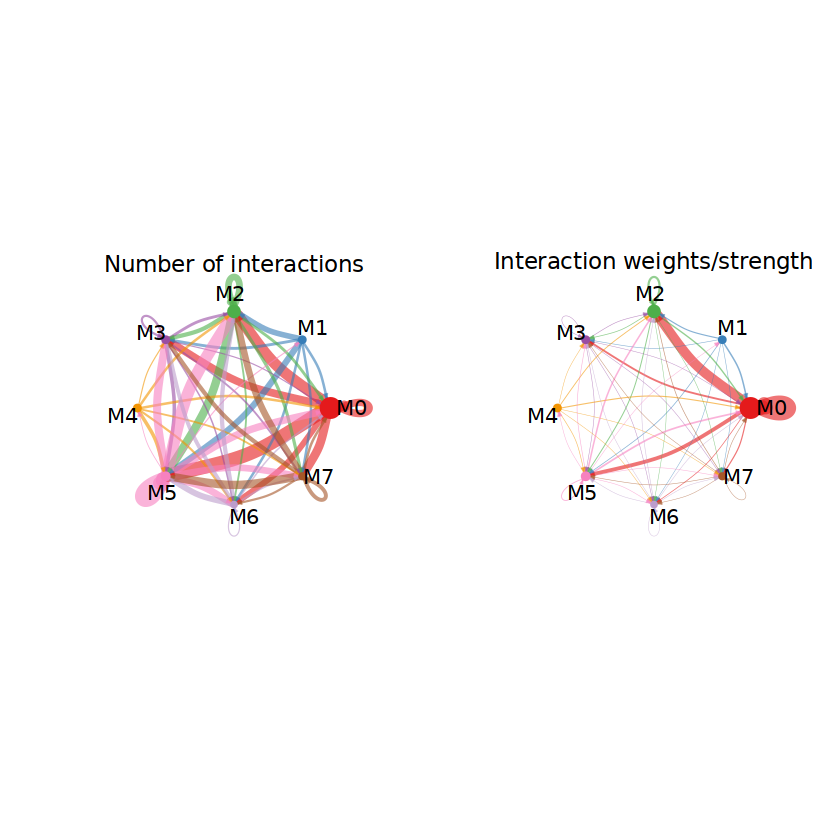

In [21]:
cellchat <- aggregateNet(cellchat)
#计算每种细胞各有多少个
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, 
                     label.edge= F, title.name = "Interaction weights/strength")

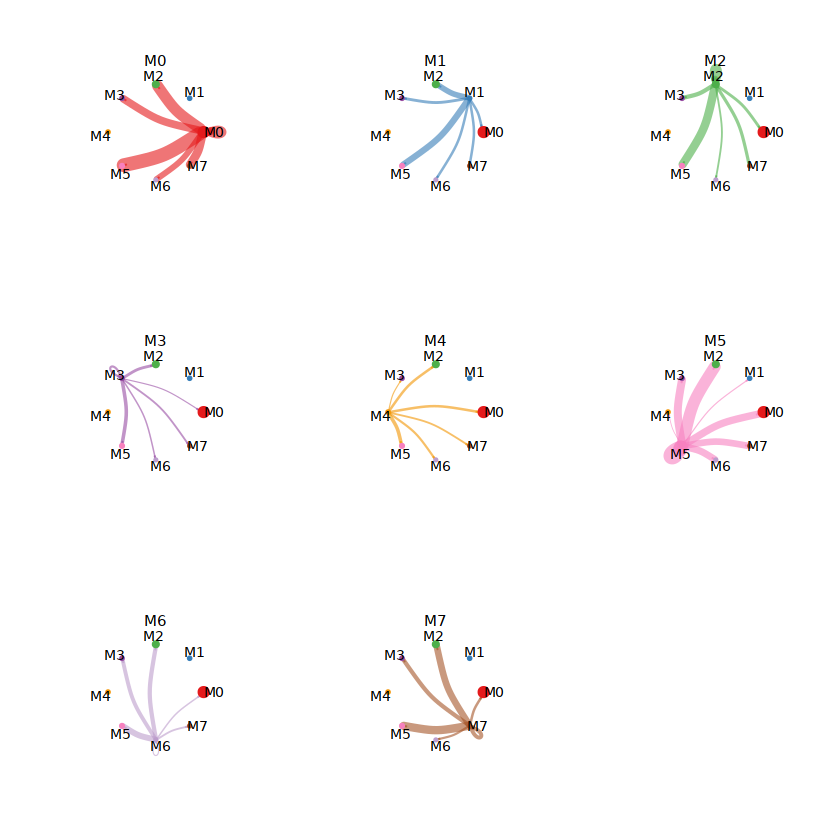

In [22]:
mat <- cellchat@net$count
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  # i = 1
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                    arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_number_individual.pdf

## 运行上述代码出现报错 Error in plot.new() : figure margins too large
# par("mar")
## [1] 5.1 4.1 4.1 2.1
# par(mar=c(1,1,1,1))
# 重新运行上面的代码

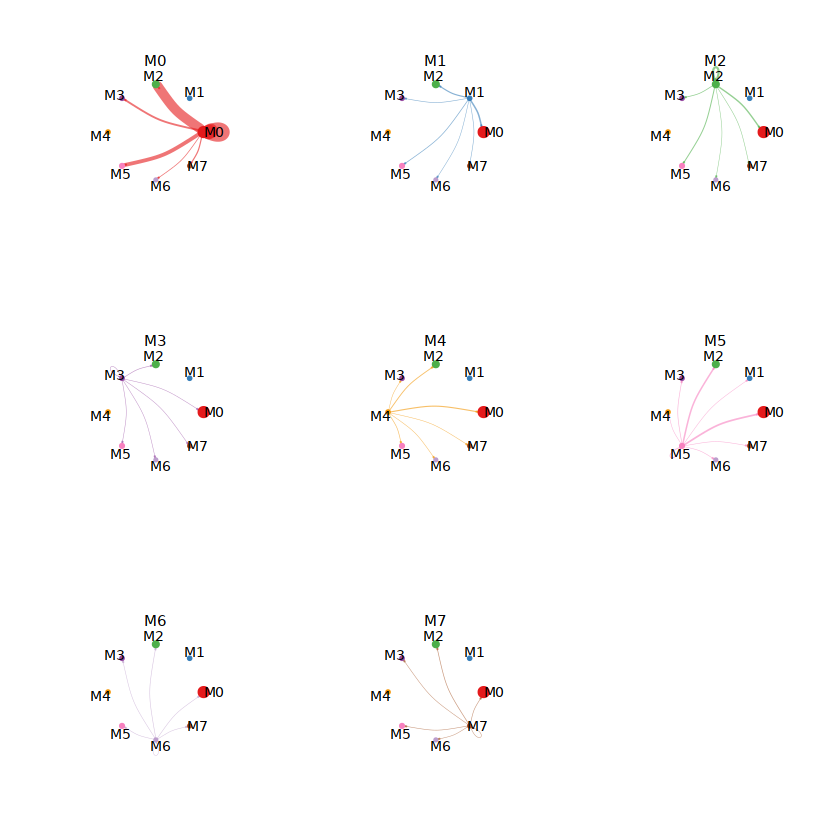

In [23]:
mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=T)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                   arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
# save as TIL/net_strength_individual.pdf

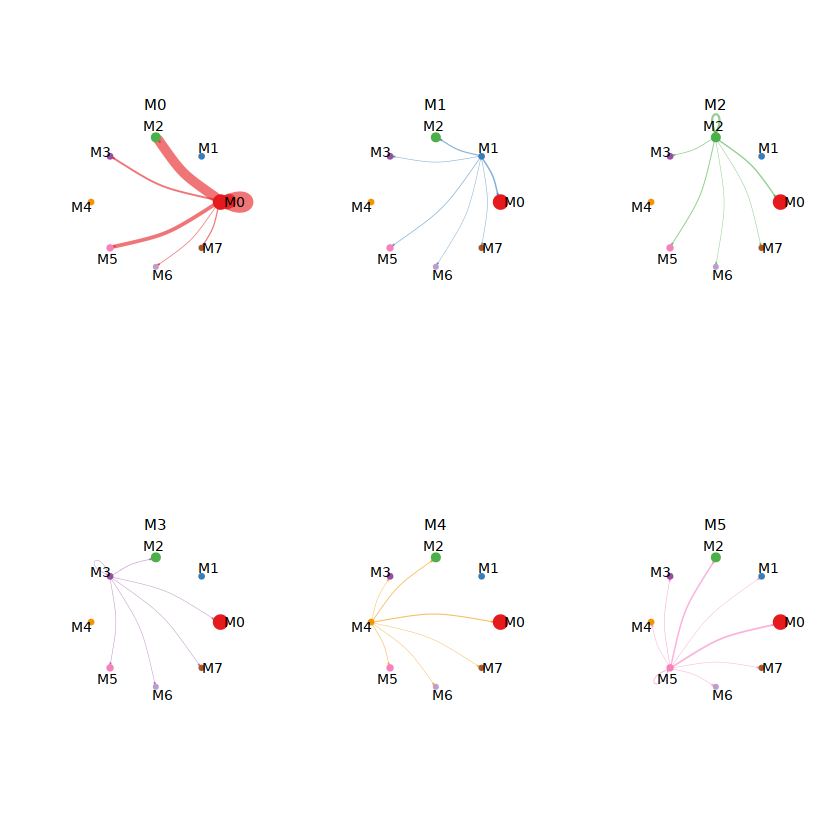

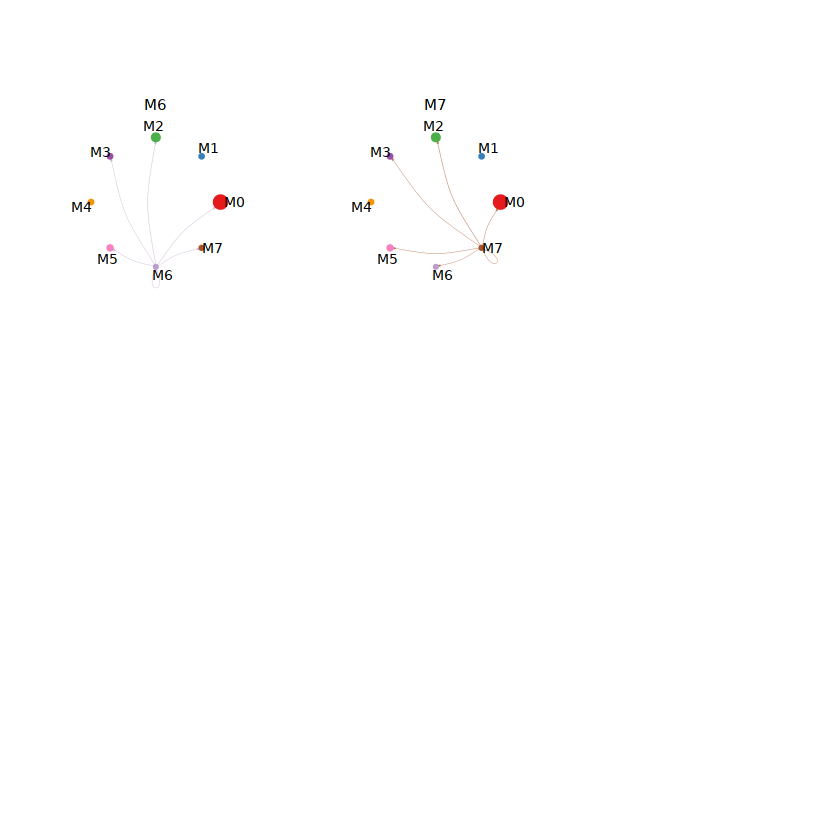

In [24]:
mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=T)
for (i in 1:nrow(mat)) {
      mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
      mat2[i, ] <- mat[i, ]
      netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, arrow.width = 0.2,
                       arrow.size = 0.1, edge.weight.max = max(mat), title.name = rownames(mat)[i])
    }
# save as TIL/net_strength_individual.pdf

In [31]:
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

In [32]:
cellchat@netP$pathways  

[1] "SPP1"       "CCL"        "GALECTIN"   "MIF"        "VISFATIN"  
 [6] "TGFb"       "TNF"        "GDF"        "IGF"        "IL10"      
[11] "CXCL"       "CSF"        "TWEAK"      "COMPLEMENT" "GAS"       
[16] "APRIL"      "ANNEXIN"    "HGF"        "PROS"       "OSM"

In [34]:
pathways.show <- cellchat@netP$pathways

[1] "M0" "M1" "M2" "M3" "M4" "M5" "M6" "M7"

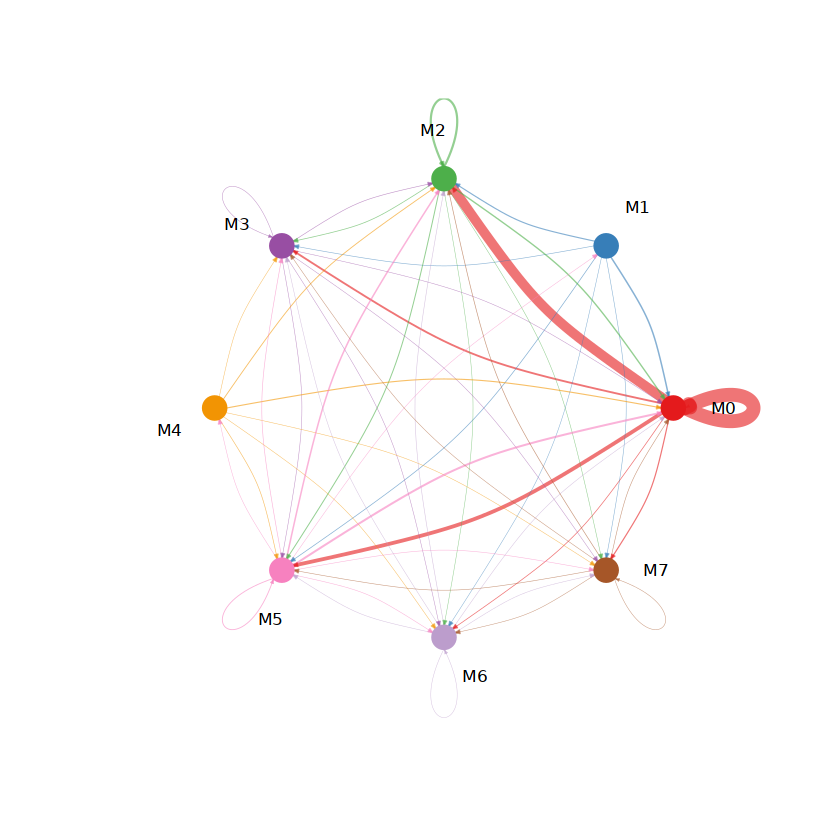

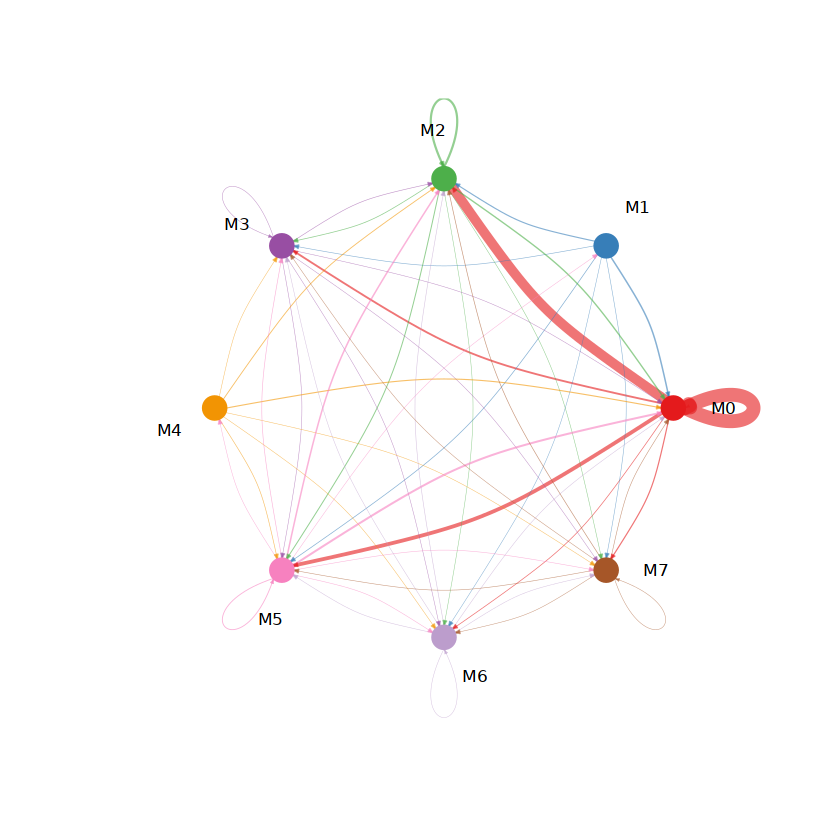

In [35]:
levels(cellchat@idents)    # show all celltype
# [1] "Naive CD4 T"  "Memory CD4 T" "CD14+ Mono"   "B"            "CD8 T"       
# [6] "FCGR3A+ Mono" "NK"           "DC"           "Platelet"    
vertex.receiver = c(1,2,4,6) # define a numeric vector （淋系细胞）giving the index of the celltype as targets
#par(mar=c(5.1,4.1,4.1,2.1))
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy.pdf

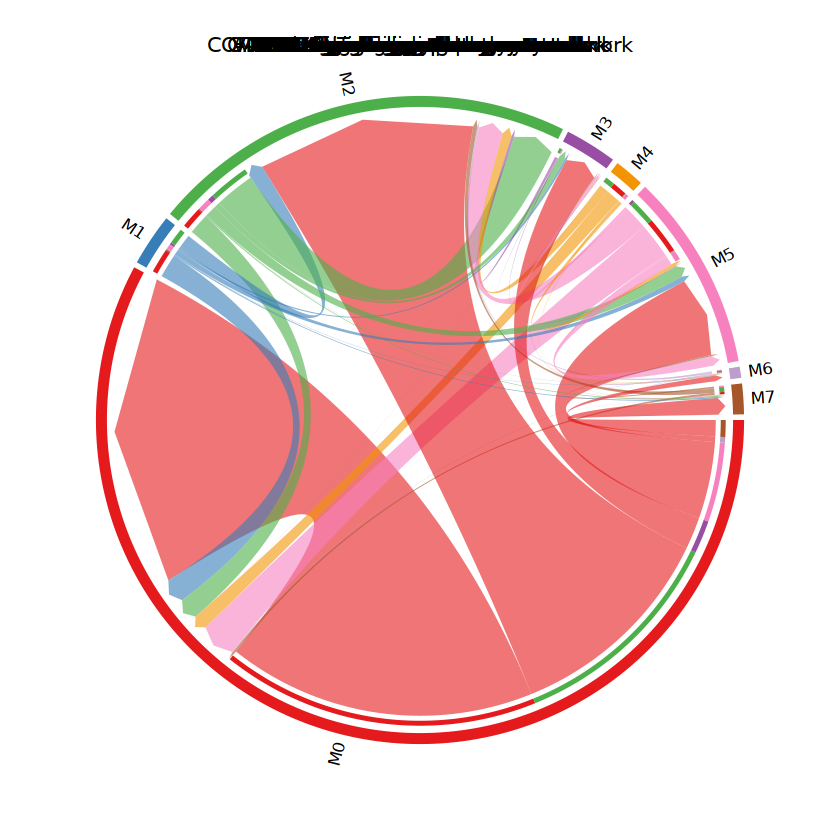

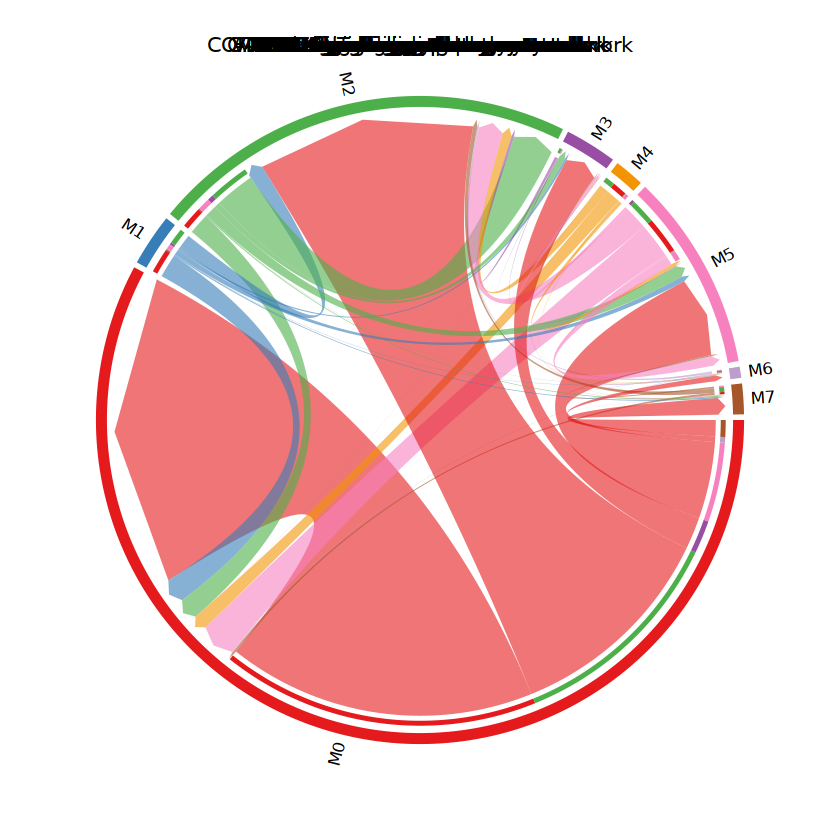

In [36]:
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
# save as TIL/CXCL_chord.pdf

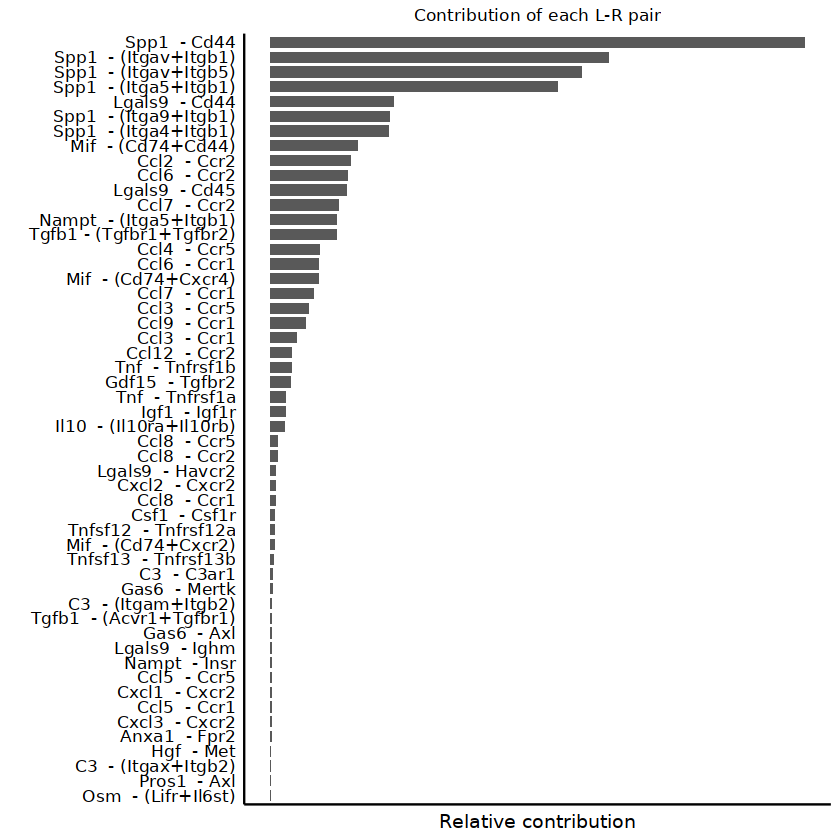

In [37]:
#计算配体受体对选定信号通路的贡献值（在这里就是查看哪条信号通路对TGFb贡献最大）
netAnalysis_contribution(cellchat, signaling = pathways.show)
pairLR.TGFb <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE) #提取对TGFb有贡献的所有配体受体 
# save as TIL/CXCL_LR_contribution.pdf

[[1]]


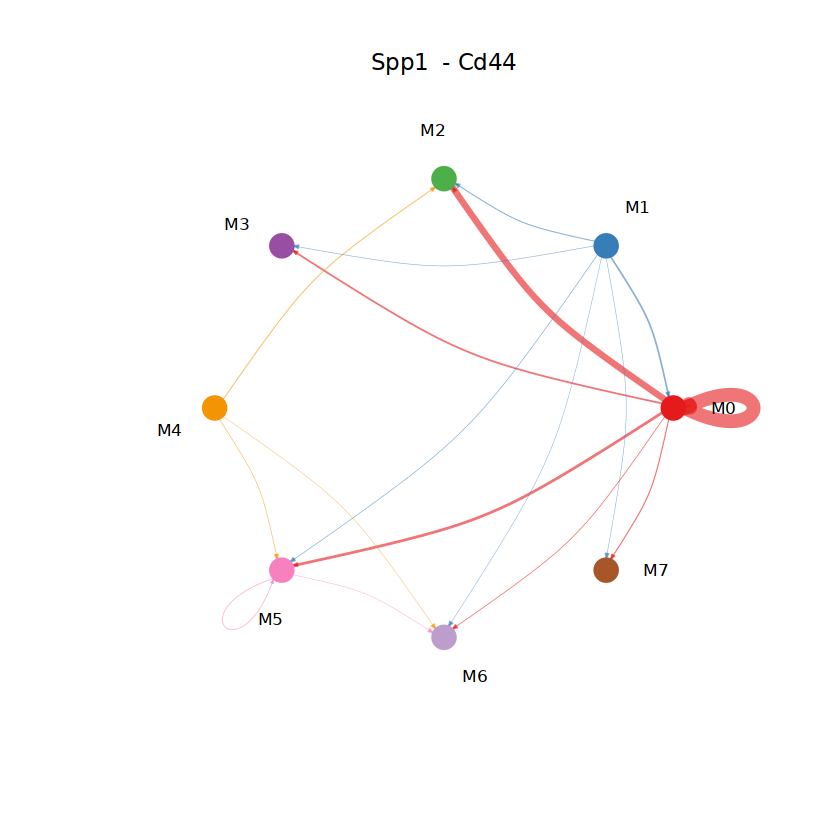

In [38]:
#提取对这个通路贡献最大的配体受体对来展示（也可以选择其他的配体受体对）
LR.show <- pairLR.TGFb[1,] 
vertex.receiver = c(1,2,4,6) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
# save as TIL/CXCL_hierarchy2.pdf

In [39]:
levels(cellchat@idents)
# show all the significant interactions (L-R pairs)
#需要指定受体细胞和配体细胞
p = netVisual_bubble(cellchat, sources.use = c(3,5,7,8), 
                     targets.use = c(1,2,4,6), remove.isolate = FALSE)
#ggsave("Mye_Lymph_bubble.pdf", p, width = 8, height = 12) #髓系对淋巴的调节
# save as TIL/Mye_Lymph_bubble.pdf

[1] "M0" "M1" "M2" "M3" "M4" "M5" "M6" "M7"

Comparing communications on a single object 




In [40]:
cellchat <- computeCommunProbPathway(cellchat)

cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

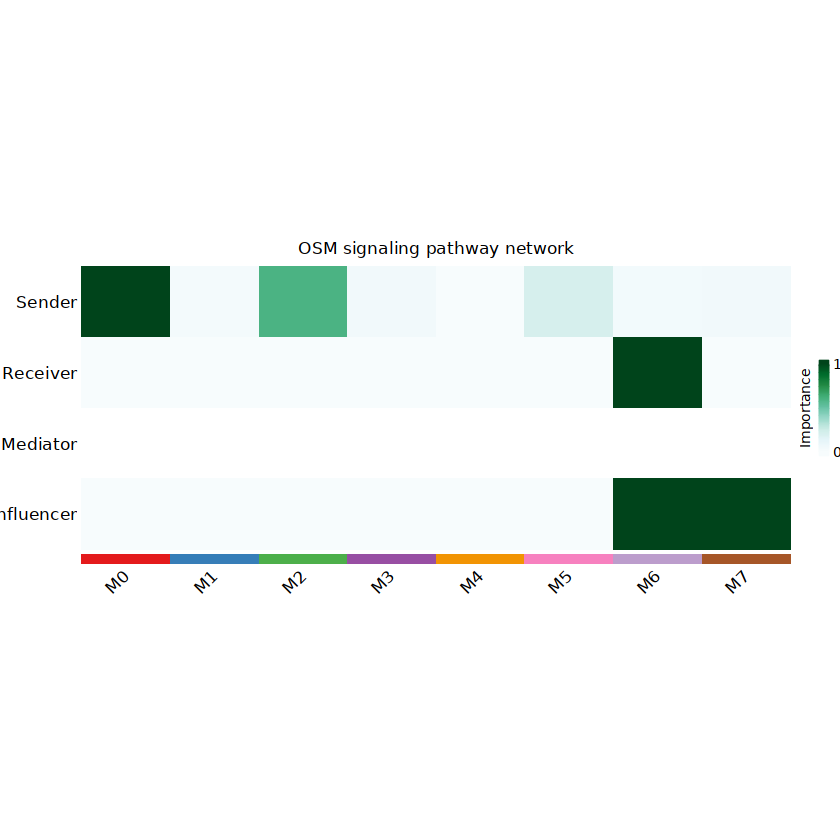

In [41]:
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                   width = 15, height = 6, font.size = 10)
# # save as TIL/SNA_CXCL_signalingRole.pdf

In [42]:
write.csv(df.net, "cell-cell_communications.all.wt3d.csv")
saveRDS(cellchat,file =  'wt3d.cellchat.rds')

In [43]:
cellchat <- createCellChat(object = ko,
                           meta = ko@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.mouse 
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=5)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- projectData(cellchat, PPI.mouse)
library(future)
options(future.globals.maxSize= 4000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 1)
df.net <- subsetCommunication(cellchat)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  M0 M1 M2 M3 M4 M5 M6 M7 


An object of class CellChat created from a single dataset 
 34329 genes.
 6816 cells. 
CellChat analysis of single cell RNA-seq data! 

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-07-05 04:22:53]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-07-05 04:28:30]"


In [44]:
write.csv(df.net, "cell-cell_communications.all.ko3d.csv")
saveRDS(cellchat,file =  'ko3d.cellchat.rds')